# New Session


In [ ]:
! pip install rasterio
! pip install rioxarray
! pip install geopandas
import rasterio
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import gdalconst
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import mapping

**scaling QA Band pixel size (60m to 10m)**

In [ ]:
input = '/content/sample_data/Sentinel-20220129_QA1.tif'
output = '/content/sample_data/Sentinel-20220129_mask-output.tif'
reference = '/content/sample_data/Sentinel-20220129_B41.tif'

def resample(outputfile,inputfile, referencefile ):

    # getting the input and reference
    input = gdal.Open(inputfile, gdalconst.GA_ReadOnly)
    reference = gdal.Open(referencefile, gdalconst.GA_ReadOnly)

    # getting the projection of input
    inputProj = input.GetProjection()


    # getting the projection of reference
    referenceProj = reference.GetProjection()
    # getting the transformation of reference
    referenceTrans = reference.GetGeoTransform()
    # getting the pixelSize in X and Y Direction
    x = reference.RasterXSize
    y = reference.RasterYSize

  # Creating the driver for output
    driver = gdal.GetDriverByName('GTiff')
    output = driver.Create(outputfile, x, y, 2,gdal.GDT_Byte)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)
    dstband = output.GetRasterBand(1)
    dstband.SetNoDataValue(0)
    gdal.ReprojectImage(input, output, inputProj, referenceProj, 10)

resample(output, input, reference)

**NDVI calculation And Cloud Masking**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


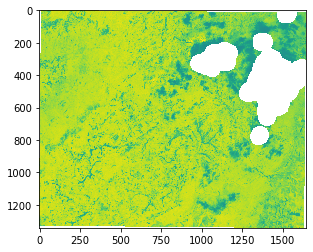

In [ ]:
dsMsk = gdal.Open(output)
msk = dsMsk.GetRasterBand(1)
mskArr = msk.ReadAsArray()
bitmask = np.where((mskArr == 255),np.NaN,1)

with rasterio.open('/content/sample_data/Sentinel-20220129_B41.tif') as src:
    b4_data = src.read(1)

with rasterio.open('/content/sample_data/Sentinel-20220129_B81.tif') as src:
    b8_data = src.read(1)

# Scale surface reflectance and cloud masking
b4_data = (b4_data /10000)*bitmask
b8_data = (b8_data /10000)*bitmask

ndvi_masked = (b8_data - b4_data) / (b8_data + b4_data)
plt.imshow(ndvi_masked, interpolation='none', vmin=-1, vmax=1)
plt.show()



# save


**Exporting Masked NDVI**

In [ ]:
gt = dsMsk.GetGeoTransform()
proj = dsMsk.GetProjection()

# export
driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("/content/sample_data/ndvi_masked.tif", xsize = ndvi_masked.shape[1],
                      ysize = ndvi_masked.shape[0], bands = 1,
                      eType = gdal.GDT_Float32)
outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(ndvi_masked)
outband.SetNoDataValue(np.nan)
outband.FlushCache()
outband = None
outds = None












**generating shapefile (polygon 1 sq km)**

In [ ]:
geom = Polygon([[78.32800647363,11.32197510223],[78.32803746365,11.27786339010],[78.37295057310,11.27789373401],[78.37291958307,11.32200544147]])
poly = gpd.GeoDataFrame(pd.DataFrame(['p1'], columns = ['geom']),
     crs = {'init':'epsg:4326'},
     geometry = [geom])

# reproject shapefile
reprojected_shp = poly.to_crs({'init': 'epsg:32644'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Clipping NDVI

<Figure size 432x288 with 0 Axes>

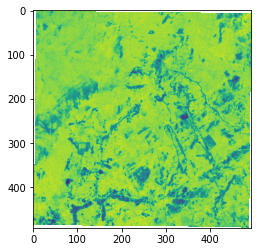

<Figure size 432x288 with 0 Axes>

In [ ]:
msk_ndvi = rxr.open_rasterio("/content/sample_data/ndvi_masked.tif",
                                 masked=True).squeeze()
NDVI_clipped = msk_ndvi.rio.clip(reprojected_shp.geometry.apply(mapping))
plt.imshow(NDVI_clipped)
plt.figure()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
